In [0]:

# Code to read csv file into colaboratory:# Code  
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'10Xf2Xv_pfnIycH2HpNZR3SwWHiHdrqzX'}) # replace the id with id of file you want to access
downloaded.GetContentFile('handwritten.csv')  

#3. Read file as panda dataframe
import pandas as pd
data = pd.read_csv('handwritten.csv')

In [0]:
!pip install -q keras
!pip install -q numpy
!pip install -q sklearn
!pip install -q matplotlib
!pip install -q pandas

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.model_selection import train_test_split

# Load the Data

In [4]:
# Get the data from the csv file
data = data.values
np.random.shuffle(data)

# Split the data into X, Y, and parition the values into the training and test splits
# Reshape X to be in the shape (N, 28, 28)
X, Y = data[:,1:], data[:,0]
# X = X.reshape(X.shape[0], 28, 28)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print("Train {} {}".format(X_train.shape, Y_train.shape))
print("Test {} {}".format(X_test.shape, Y_test.shape))

Train (297629, 784) (297629,)
Test (74408, 784) (74408,)


# Data Prep

In [5]:
classes = np.unique(Y_train)
n_classes = len(classes)
print('Total number of outputs : ', n_classes)
print('Output classes : ', classes)

Total number of outputs :  26
Output classes :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


In [0]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

classes = np.unique(Y_train)
num_classes = len(classes)

X_train = X_train.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

## Normalize Images

In [0]:
mean_image = np.mean(X_train, axis=0).astype(np.int64)
X_train = (X_train - mean_image)/255
X_test = (X_test - mean_image)/255

In [8]:
from keras.utils import to_categorical

Y_train_onehot = to_categorical(Y_train)
Y_test_onehot = to_categorical(Y_test)
print("Original Label: {}".format(Y_train[0]))
print("One Hot Label: {}".format(Y_train_onehot[0]))

Using TensorFlow backend.


Original Label: 12
One Hot Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [0]:
# X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train_onehot, test_size=0.2)

# print("Train: {} {}".format(X_train.shape, Y_train.shape))
# print("Valid: {} {}".format(X_valid.shape, Y_valid.shape))

# Testing Layers

In [0]:
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.layers import LeakyReLU, ELU
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

from tensorflow.python.keras import initializers

optimizer = Adam(lr=1e-3)

In [0]:
model = Sequential()

#conv
#keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, 
    #dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', 
    #bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, 
    #activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
model.add(Conv2D(filters=16, kernel_size=8, strides = 1, padding='same', activation='linear',
                 bias_initializer='RandomNormal', input_shape=(img_size,img_size,1)))

#ReLu
model.add(LeakyReLU(alpha=0.1))

#conv2
model.add(Conv2D(filters=8, kernel_size=8, strides = 2, padding='same', activation='linear',
                 bias_initializer='RandomNormal', input_shape=(img_size,img_size,1)))

#ReLu
model.add(LeakyReLU(alpha=0.1))

#MaxPool
#keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
model.add(MaxPooling2D(strides=2, padding='same'))

#Affine
model.add(Flatten())

#keras.layers.Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', 
    #bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, 
    #activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
#model.add(Dense(56, activation="relu"))
    
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#model.summary()

# Cross Validation

In [12]:
from sklearn.model_selection import KFold

k_fold = KFold(n_splits=3)
best_acc = 0
best_model = None

for train_indices, val_indices in k_fold.split(X_train):
  print("Starting new fold")
  print(train_indices, val_indices)
  
  model_train = model.fit(x=X_train[train_indices], y=Y_train_onehot[train_indices],
                          epochs=3, batch_size=128,verbose=1, 
                          validation_data=(X_train[val_indices], Y_train_onehot[val_indices]))
  
  test_eval = model.evaluate(X_test, Y_test_onehot, verbose=0)
  print('Test loss:', test_eval[0])
  print('Test accuracy:', test_eval[1])
  if test_eval[1] > best_acc:
    best_acc = test_eval[1]
    best_model = model_train

print("Best accuracy:", best_acc )
  

#X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train_onehot, test_size=0.2)

#   print("Train: {} {}".format(X_train[train_indices].shape, Y_train[train_indices].shape))
#   print("Valid: {} {}".format(X_train[val_indices].shape, Y_train_onehot.shape))

Starting new fold
[ 99210  99211  99212 ... 297626 297627 297628] [    0     1     2 ... 99207 99208 99209]
Train on 198419 samples, validate on 99210 samples
Epoch 1/3
196864/198419 [============================>.] - ETA: 0s - loss: 0.4220 - acc: 0.8814198419/198419 [==============================] - 29s 146us/step - loss: 0.4199 - acc: 0.8819 - val_loss: 0.1597 - val_acc: 0.9567
Epoch 2/3
198419/198419 [==============================] - 26s 131us/step - loss: 0.1424 - acc: 0.9620 - val_loss: 0.1207 - val_acc: 0.9685
Epoch 3/3
 14464/198419 [=>............................] - ETA: 20s - loss: 0.1137 - acc: 0.9681198419/198419 [==============================] - 26s 129us/step - loss: 0.1188 - acc: 0.9684 - val_loss: 0.1168 - val_acc: 0.9686
Test loss: 0.12055748531663162
Test accuracy: 0.9666030534351145
Starting new fold
[     0      1      2 ... 297626 297627 297628] [ 99210  99211  99212 ... 198417 198418 198419]
Train on 198419 samples, validate on 99210 samples
Epoch 1/3
 75008/198

# Ignore Below

In [12]:
model_train = model.fit(x=X_train,
          y=Y_train,
          epochs=10, batch_size=128,verbose=1, validation_data=(X_valid, Y_valid))

Train on 238103 samples, validate on 59526 samples
Epoch 1/10
238103/238103 [==============================] - 32s 134us/step - loss: 0.3429 - acc: 0.9038 - val_loss: 0.1575 - val_acc: 0.9571
Epoch 2/10
 52096/238103 [=====>........................] - ETA: 21s - loss: 0.1444 - acc: 0.9602238103/238103 [==============================] - 29s 123us/step - loss: 0.1363 - acc: 0.9634 - val_loss: 0.1225 - val_acc: 0.9673
Epoch 3/10
152192/238103 [==================>...........] - ETA: 9s - loss: 0.1128 - acc: 0.9697238103/238103 [==============================] - 29s 122us/step - loss: 0.1122 - acc: 0.9700 - val_loss: 0.1094 - val_acc: 0.9700
Epoch 4/10
191872/238103 [=======================>......] - ETA: 5s - loss: 0.1023 - acc: 0.9732238103/238103 [==============================] - 29s 121us/step - loss: 0.1016 - acc: 0.9732 - val_loss: 0.1016 - val_acc: 0.9726
Epoch 5/10
205824/238103 [========================>.....] - ETA: 3s - loss: 0.0919 - acc: 0.9753238103/238103 [==================

In [13]:
test_eval = model.evaluate(X_test, Y_test_onehot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.08747778082487966
Test accuracy: 0.977771207397054


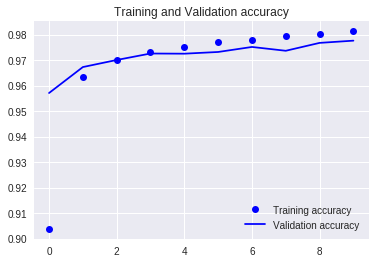

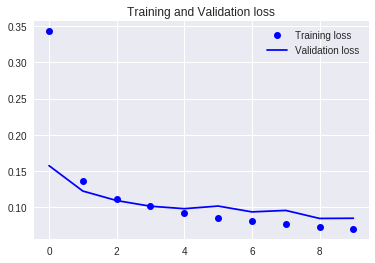

In [14]:

accuracy = model_train.history['acc']
val_accuracy = model_train.history['val_acc']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()